### Group Members:

- Shantam raj, 21-743-034
- Jorge Alejandro Ortiz Valerio, 23-743-958
- Varun Ghat Ravikumar,  23-744-535

# Assignment 9: Convolutional Auto-Encoder

In this assignment, we show that it is possible to learn from unlabeled data using a convolutional auto-encoder network.
The task is to reduce an image of the handwritten digits of MNIST into a deep feature representation, without making use of their labels, and reconstruct the sample from that representation.

For this purpose, we implement a convolutional auto-encoder that learns a $K=10$-dimensional deep feature representation of each image and uses this representation to reconstruct images to the original size of $28\times28$ pixels.
We show that such a network can be used to detect anomalies in the test set.

## Dataset

We will make use of `torchvision.datasets.MNIST` dataset and `torchvision.datasets.FashionMNIST` dataset.
The former has 10 labels of digit images and the latter has 10 labels of merchandise images.
However, besides the last task, we do not make use of the labels of the dataset, but we only utilize the images.

These datasets can be split into train sets and test sets by the default implementation.
We will use solely MNIST dataset for training and validation of autoencoder network.
To use this network for anomaly detection, we will create a new testing set by combining the whole test set of MNIST and a
randomly selected subset of FashionMNIST test set.

### Task 1: Datasets
Write a dataset class that derives from `torch.utils.data.Dataset` that returns three values: data, target, and anomaly label. Implement the following three functions:

1. The constructor `__init__(self, root, purpose, transform, anomaly_size)`. `root` is the saving path of dataset, `purpose` should be `train`, `val`, or `anomaly_detection`, and `anomaly_size` decides the number of test samples from FashionMNIST dataset. `torchvision.datasets.MNIST` and `torchvision.datasets.FashionMNIST` should be appropriately called here depending on `purpose`. Particularly, when `purpose=anomaly_detection`, a subset of FashionMNIST dataset should be randomly selected with size `anomaly_size`.
2. The function `__len__(self)` returns the number of samples in our dataset.
3. The index function `__getitem__(self, idx)` returns image, target, and data type indicator (-1 if anomalous, 1 otherwise) for a given index.

In [129]:
import torch
import torchvision

class MixedDataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', purpose="train", transform=None, anomaly_size=2000):
        # load MNIST dataset based on "purpose"
        self.purpose = purpose

        self.mnist_dataset = torchvision.datasets.MNIST(root = root, 
                                                        train = True if purpose=="train" else False,
                                                        download=True,
                                                        transform=transform,                                                       
                                                       )
        self.dataset = self.mnist_dataset

        self.data_type = torch.ones(len(self.dataset))
        
        # load FashionMNIST dataset when "purpose" is "anomaly_detection" and randomly select samples with size "anomaly_size"
        if purpose=="anomaly_detection":
            self.fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root = root,
                                                                          train = True if purpose=="train" else False,
                                                                          download = True,
                                                                          transform = transform,
                                                                          )
            
            
            indices = torch.randperm(len(self.fashion_mnist_dataset))[:anomaly_size]
            self.subset = torch.utils.data.Subset(self.fashion_mnist_dataset,indices)

            self.dataset = torch.utils.data.ConcatDataset([self.dataset,self.subset])

            self.data_type = torch.cat((self.data_type,(torch.zeros(len(self.subset)) - 1)))
            
        
        

    def __len__(self):
        # return length of the desired dataset based on its purpose
        return len(self.dataset)

    def __getitem__(self, idx):
        # perform appropriate actions on the data, target, and its data type indicator (return 1 for regular and -1 for anomalous)
        image,target = self.dataset[idx]
        data_type = self.data_type[idx]

        return image, target, data_type


### Task 2: Data Loader

Call the dataset class three times, use `torchvision.transforms.ToTensor()` as transform, with purpose = `train` (batch size = 32), `val` (batch size = 100), and `anomaly_detection` (batch size = 1000). The third dataset has `anomaly_size=2000`.
Instantiate data loader for the three datasets.
Remember to shuffle the third dataset.

In [130]:
# define transform
transform = torchvision.transforms.ToTensor()

# instantiate training dataset and data loader
train_dataset = MixedDataset(purpose="train",transform = transform)
train_loader = torch.utils.data.DataLoader(train_dataset,32,shuffle=True)


# instantiate validation dataset and data loader
val_dataset = MixedDataset(purpose="val",transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset,100)

# instantiate anomaly detection dataset and data loader
anomaly_detection_dataset = MixedDataset(purpose="anomaly_detection",transform=transform,anomaly_size=2000)
anomaly_detection_loader = torch.utils.data.DataLoader(anomaly_detection_dataset,1000,shuffle=True)



### Test 1: Data Check

Load one batch of train set, validation set, and anomaly detection set.
For each set, check that input size of each sample is (1, 28, 28), targets are between 0 and 9, and the data type for the first two sets is 1 and there are -1 in the last set.

Plot 20 samples from validation loader and 20 samples from anomaly detection loader and check whether samples from FashionMNIST are correctly loaded.

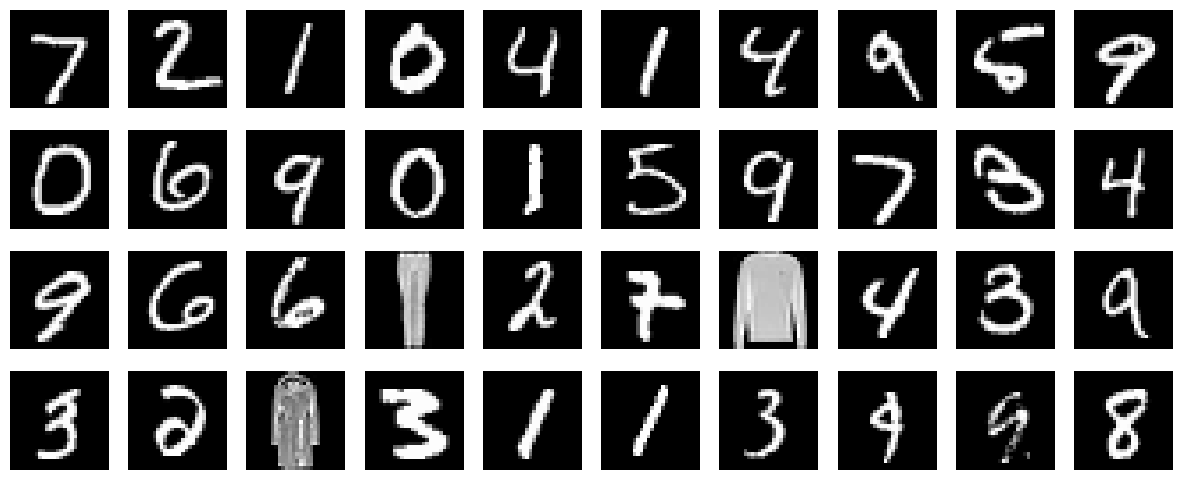

In [131]:
from matplotlib import pyplot

pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(nrows=4, ncols=10, figsize=(15, 6))

x_train, t_train, l_train = next(iter(train_loader))
x_val, t_val, l_val = next(iter(val_loader))
x_ad, t_ad, l_ad = next(iter(anomaly_detection_loader))

assert len(train_dataset) == 60000
assert len(val_dataset) == 10000
assert len(anomaly_detection_dataset) == 12000
assert x_train[0].shape == (1, 28, 28)
assert x_val[0].shape == (1, 28, 28)
assert x_ad[0].shape == (1, 28, 28)
assert 0 <= t_train.all() <= 9
assert 0 <= t_val.all() <= 9
assert 0 <= t_ad.all() <= 9
assert (l_val == 1).all()
assert (l_train == 1).all()
assert -1 in l_ad

index=0
for i in range(2):
    for j in range(10):
        axes[i][j].imshow(x_val[index].squeeze())
        axes[i][j].axis("off")
        axes[i+2][j].imshow(x_ad[index].squeeze())
        axes[i+2][j].axis("off")
        index+=1

## Auto-Encoder Network

The auto-encoder network is composed of two parts: the encoder that transforms the input image to a deep feature representation; and the decoder that produces an image from such a deep feature.

For the encoder $\mathcal E$, we will use a similar convolutional network topology as in the past assignments.
An exception is that we perform our down-sampling via striding and not via pooling.
After each convolution, we apply the ReLU activation.
The output of the encoder is a $K=10$ dimensional deep feature representation.
The complete encoder network topology can be found below in Topology 1(a).

The decoder $\mathcal D$ performs the inverse operations of the encoder.
A fully-connected layer is used to increase the number of samples to the same size as the output of the flattening of the encoder.
Then, the flattening needs to be undone by reshaping the vector into the correct dimensionality, followed by a ReLU activation.
A fractionally-strided convolutional layer increases the intermediate representation by a factor of 2.
Note that the fractionally-strided convolution is implemented in `torch.nn.ConvTranspose2d`, and the `stride` parameter should have the same value as for the encoder.
Additionally, the `torch.nn.ConvTranspose2d` has a parameter `output_padding` which needs to be adapted to reach the correct output shape (see Test 2).
After this layer, we perform another ReLU activation and another fractionally-strided convolution to arrive at the original input dimension.
The complete decoder network topology can be found below in Topology 1(b).

Finally, we combine the two sub-networks into one auto-encoder network.
While there exist several possibilities for doing this, we will implement a third `torch.nn.Module` that contains an instance of the encoder and an instance of the decoder.

Topology 1: Network configurations of the (a) encoder and (b) decoder networks

(a) Encoder Network

*   2D convolutional layer with $Q_1$ output channels, kernel size $5\times5$, **stride 2** and padding 2
*   activation function ReLU
*   2D convolutional layer with $Q_2$ output channels, kernel size $5\times5$, **stride 2** and padding 2
*   flatten layer to convert the convolution output into a vector
*   activation function ReLU
*   fully-connected layer with the correct number of inputs and $K$ outputs

(b) Decoder Network

*   fully-connected layer with $K$ inputs and the correct number of outputs
*   activation function ReLU
*   reshaping to convert the vector into a convolution input
*   2D **fractionally-strided convolutional** layer with $Q_2$ input channels, kernel size $5\times5$, stride 2 and padding 2
*   activation function ReLU
*   2D **fractionally-strided convolutional** layer with $Q_1$ input channels, kernel size $5\times5$, stride 2 and padding 2

### Task 3: Encoder Network

Implement the encoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(a).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.

In [132]:
class Encoder (torch.nn.Module):
    def __init__(self, Q1, Q2, K):
        # call base class constrcutor
        super(Encoder,self).__init__()
        # convolutional define layers
        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = Q1, kernel_size = 5, stride = 2, padding = 2)
        self.conv2 = torch.nn.Conv2d(in_channels = Q1, out_channels = Q2, kernel_size = 5, stride = 2, padding = 2)
        # activation functions will be re-used for the different stages
        self.act = torch.nn.ReLU()
        # define fully-connected layers
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(in_features=Q2*7*7,out_features=K)

    def forward(self, x):
        # get the deep feature representation
        z1 = self.conv1(x)
        a1 = self.act(z1)
        #print(a1.shape)
        z2 = self.conv2(a1)
        #print(z2.shape)
        z3 = self.flatten(z2)
        #print(z3.shape)
        a3 = self.act(z3)
        deep_feature = self.fc(a3)
        return deep_feature


### Task 4: Decoder Network

Implement the decoder network for given parameters $Q_1$, $Q_2$, and $K$ as given in Topology 1(b).
Implement a network class that derives from `torch.nn.Module` and implement the `__init__` and the `forward` methods.
The output of the decoder network is supposed to have values in the range $[0,1]$, similar to the input values.
We need to make sure that only these values can be achieved.
Think of possible ways of doing that, and apply the way that seems most reasonable.

In [133]:
import math
class Decoder (torch.nn.Module):
    def __init__(self, Q1, Q2, K):
        # call base class constrcutor
        super(Decoder,self).__init__()
        # fully-connected layer
        self.fc = torch.nn.Linear(in_features = K,out_features = Q2*7*7)
        # convolutional layers
        self.deconv1 = torch.nn.ConvTranspose2d(in_channels=Q2,out_channels = Q1,kernel_size=5,stride=2,padding=2,output_padding=1)
        self.deconv2 = torch.nn.ConvTranspose2d(in_channels=Q1,out_channels = 1,kernel_size=5,stride=2,padding=2,output_padding=1)
        # activation function
        self.act = torch.nn.ReLU()

    def forward(self, x):
        # reconstruct the output image
        z1 = self.fc(x)
        a1 = self.act(z1)
        channels = a1.shape[1]//(7*7)
        #print(a1.shape)
        a1_reshaped = torch.reshape(a1,(a1.shape[0],channels,7,7))
        #print(a1_reshaped.shape)
        z2 = self.deconv1(a1_reshaped)
        a2 = self.act(z2)
        #print(a2.shape)
        output = self.deconv2(a2)
        #print(output.shape[2:])
        return torch.sigmoid(output)

### Task 5: Joint Auto-Encoder Network

Implement the auto-encoder network by combining the encoder and the decoder.
In the `__init__` function, instantiate an encoder from Task 3 and a decoder from Task 4.
In `forward`, pass the input through the encoder and the decoder: $\mathbf Y = \mathcal D(\mathcal E(\mathbf X))$

In [134]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, Q1, Q2, K):
        super(AutoEncoder,self).__init__()
        self.encoder = Encoder(Q1,Q2,K)
        self.decoder = Decoder(Q1,Q2,K)

    def forward(self,x):
        # encode input
        deep_feature = self.encoder.forward(x)
        # decode to output
        reconstructed = self.decoder.forward(deep_feature)
        return reconstructed

### Test 2: Output Sizes

The code below instantiates the auto-encoder network with $Q_1 = Q_2 = 32$ and $K=10$.
Then the given input $\mathbf X$ is provided to the (untrained) auto-encoder network.
Use these codes to verify that the deep feature extracted by the encoder and the output from the decoder part both have the desired size. Also, verify that the output values are between 0 and 1.

If the tests cannot be passed, please check the implementation in Task 3, 4, and 5.

In [135]:
# run on cuda device?

device = torch.device("cuda") if torch.cuda.is_available() == True else torch.device("cpu")
print(device)

# create network
network = AutoEncoder(32, 32, 10).to(device)

# create or select a sample
x = torch.randn((1,1,28,28))

# use encoder to encode image and check its size
deep_features = network.encoder(x.to(device))
assert deep_features.shape[1] == 10

# use decoder to generate an image and check its size and value range
output = network.decoder(deep_features)
assert output.shape[2:] == (28,28)
assert torch.all(output >= 0) and torch.all(output <= 1)

cuda


## Training and Evaluation
We will implement a training procedure for an auto-encoder network.

To train the network, we will use the $L_2$ distance between the output and the input of the network as a loss function, which is implemented in `torch.nn.MSELoss`:

  $$\mathcal J^{L_2} (\mathbf X, \mathbf Y) = \|\mathbf X - \mathbf Y\|^2$$

For optimization, we will make use of the `Adam` optimizer with a learning rate of $\eta=0.001$.
We will run the training for 10 epochs and compute training and validation set loss after each epoch.

For evaluation, we will check whether some of the validation set samples are correctly reconstructed from the auto-encoder network by visualizing them in Task 9.

In our defined anomaly detection validation set, there are 10000 regular samples and 2000 anomalous samples.
In the case of evaluating the success rate of anomaly detection (Task 7 & 8), accuracy is not the best metric because it gives equal weights to two classes with unequal numbers of samples, while the actual distribution of the two classes is unbalanced.
A system can achieve high accuracy by simply predicting the majority class for every instance, while completely ignoring the minority class.

In such cases, we choose to use the true positive rate (TPR) and true negative rate (TNR), which measure the proportion of actual positive/negative cases that are correctly identified by the system.

$$\text{TPR} = \frac{\text{True Positives}}{\text{True Positives+False Negatives}} = \frac{\text{True Positives}}{\text{Positives}}$$

$$\text{TNR} = \frac{\text{True Negatives}}{\text{True Negatives+False Positives}} = \frac{\text{True Negatives}}{\text{Negatives}}$$


### Task 6: Training Loop

Instantiate the auto-encoder network with $Q_1 = Q_2 = 32$ and $K=10$.

To train the auto-encoder network, we will use the $L_2$ distance between the output and the input of the network as a loss function.
This loss function is implemented in `torch.nn.MSELoss`.

Since training an auto-encoder is tricky, we will make use of the Adam optimizer.
Choose a learning rate of $\eta=0.001$. Implement the training loop for 10 epochs.

Compute the average training loss and validation loss and print them at the end of each epoch. Note: If the training and validation loss does not decrease during training, try to reduce the learning rate (to $\eta=0.0005$ or even lower) and re-start the training (remember to re-initialize the network, too).



In [136]:
from tqdm import tqdm


ETA = 0.0005
EPOCHS = 10

# set device if available
device = torch.device("cuda") if torch.cuda.is_available() == True else torch.device("cpu")
print(device)

# create network
network = AutoEncoder(Q1=32,Q2=32,K=10)
network.to(device)

# define optimizer
optimizer = torch.optim.Adam(params=network.parameters(),lr=ETA)

# define loss function
loss = torch.nn.MSELoss()

for epoch in tqdm(range(EPOCHS)):
    # evaluate average loss for training and validation set per epoch
    train_loss = validation_loss = 0.

    for x,_,_ in train_loader:

        # compute netwok output
        optimizer.zero_grad()
        x = (x/1).to(device)
        y = network(x)
        # compute loss between output and input
        J = loss(y,x)

        # perform update
        J.backward()
        optimizer.step()

        # accumulate loss
        train_loss += J


    # compute validation loss
    with torch.no_grad():
        for x,t,_ in val_loader:
            x = (x/1).to(device)
            # compute network output
            y = network(x)
            # compute loss
            J = loss(x,y)
            # accumulate loss
            validation_loss += J


    # print average loss for training and validation
    print(f"\rEpoch {epoch+1}; train: {train_loss/len(train_dataset):1.5f}, val: {validation_loss/len(val_dataset):1.5f}")

cuda


 10%|████████▎                                                                          | 1/10 [00:11<01:44, 11.59s/it]

Epoch 1; train: 0.00108, val: 0.00021


 20%|████████████████▌                                                                  | 2/10 [00:22<01:30, 11.37s/it]

Epoch 2; train: 0.00061, val: 0.00018


 30%|████████████████████████▉                                                          | 3/10 [00:34<01:19, 11.35s/it]

Epoch 3; train: 0.00054, val: 0.00016


 40%|█████████████████████████████████▏                                                 | 4/10 [00:45<01:07, 11.29s/it]

Epoch 4; train: 0.00050, val: 0.00015


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:56<00:56, 11.24s/it]

Epoch 5; train: 0.00047, val: 0.00015


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [01:07<00:44, 11.23s/it]

Epoch 6; train: 0.00045, val: 0.00014


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:19<00:33, 11.26s/it]

Epoch 7; train: 0.00044, val: 0.00014


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:30<00:22, 11.25s/it]

Epoch 8; train: 0.00043, val: 0.00014


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:41<00:11, 11.25s/it]

Epoch 9; train: 0.00042, val: 0.00013


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:52<00:00, 11.27s/it]

Epoch 10; train: 0.00042, val: 0.00013


### Task 7: True Positive/Negative Rate Calculation

Define a function that takes the predictions and binary ground-truth values (the data type from Task 1) as lists, and returns TPR and TNR.

You can use `sklearn.metrics.confusion_matrix` (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to compute true positives, true negatives, false positives, and false negatives, or compute them by their definitions.

In [137]:
import numpy as np
from sklearn.metrics import confusion_matrix

def compute_tpr_tnr(predictions, truth):
    # convert list into numpy arrary
    predictions = np.array(predictions)
    truth = np.array(truth)
    # Compute the confusion matrix or tp, tn, fp, fn
    cf_mat = confusion_matrix(y_true = truth, y_pred = predictions)
    # Compute TPR and TNR
   
    tn, fp, fn, tp = cf_mat.ravel()
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    return tpr, tnr

### Test 3: TPR & TNR Calculation Check

With the given truth values and predictions, call the function defined in Task 7 and check the returned TPR and TNR are correct.

In [138]:
truth = [1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1]
predictions = [1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1]

tpr, tnr = compute_tpr_tnr(predictions, truth)

assert(abs(tpr - 14/15) < 1e-8)
assert(abs(tnr - 0.8) < 1e-8)


### Task 8: Anomaly Evaluation

In this task, forward the data from the anomaly detection loader into the trained network, compute sample-wise loss (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), and assign -1 to samples with loss > 0.04, and 1 to samples with loss < 0.04.

Forward the re-assigned loss as predictions into the function defined in Task 7 to compute TPR and TNR. Compute the regular accuracy as well to make a comparison.

In [139]:
# instantiate loss function with appropriate reduction
loss = torch.nn.MSELoss(reduction="none")

correct = 0.
predictions = []
truth_values = []

# compute tpr and tnr for the anomaly detection dataset
with torch.no_grad():
    for x, t, l in anomaly_detection_loader:
        # forward input to the trained network
        x = (x/1).to(device)
        y = network(x)

        # compute loss per input
        J = loss(y,x)

        # select the indexes at which loss is great then threshold 0.04 and replace its value by -1, and others by 1.
        J_samplewise = torch.mean(J,dim=(1,2,3)).cpu().detach().numpy()
        #print(J_samplewise)
        #j1 = []
        #j2 = []
        #for i,j in enumerate(J_samplewise):
        #    if(l[i]==1):
        #        j1.append(j)
        #    else:
        #        j2.append(j)
        #print("J1:",min(j1),max(j1),sum(j1)/len(j1))
        #print("J2:",min(j2),max(j2),sum(j2)/len(j2))

        
                
            
        prediction = [1 if j<0.04 else -1 for j in J_samplewise]

        # convert the prediction and l into list and add to list predictions and list truth_values
        predictions += prediction
        truth_values += l

        # compute accuracy
        correct += (np.array(prediction) == np.array(l)).sum()


# print the accuracy
acc = correct / len(predictions)

# compute tpr and tnr with function defined in Task 7 and print tpr and tnr
tpr, tnr = compute_tpr_tnr(predictions,truth_values)

print("True Positive Rate:", tpr)
print("True Negative Rate:", tnr)
print("Accuracy:", acc)

True Positive Rate: 0.9886
True Negative Rate: 0.8755
Accuracy: 0.96975


### Task 9: Reconstruction Result

This task is to visualize the reconstructed images from their originals.
For this purpose, load the first batch of the anomaly detection set. 
For both MNIST and FashionMNIST data, select one image for each label.

Forward the images through the trained auto-encoder network to extract their reconstructions.

Make a single plot with 4 rows and 10 columns. 
In the 1st/3rd row, plot the original MNIST/FashionMNIST samples, 2nd/4th row plot the corresponding reconstructed samples. 
See the reference plot in the slides.

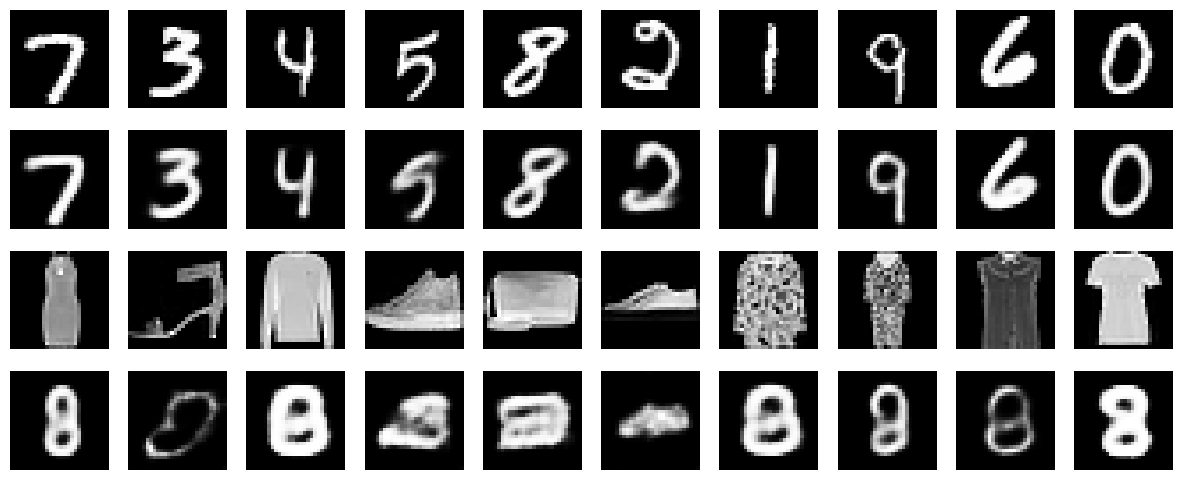

In [140]:
# get the first anomaly detection set batch
x, t, l = next(iter(anomaly_detection_loader))


# select one image for each label

num_labels = int(max(t))+1
selected_mnist = [False for i in range(num_labels)]
selected_fashion = [False for i in range(num_labels)]
count_mnist=0
count_fashion=0
data_mnist = []
data_fashion = []

for idx,target in enumerate(t):
    if(l[idx]==1):
        if(selected_mnist[target]==False):
            #print(target)
            selected_mnist[target]=True
            data_mnist.append(x[idx])
            count_mnist+=1
        if(count_mnist==num_labels and count_fashion==num_labels):
            break
    else:
        if(selected_fashion[target]==False):
            #print(target)
            selected_fashion[target]=True
            data_fashion.append(x[idx])
            count_fashion+=1
        if(count_mnist==num_labels and count_fashion==num_labels):
            break
            


# If required, convert the list of select images into a tensor through torch.stack
original_mnist = torch.stack(data_mnist)/1
original_fashionmnist = torch.stack(data_fashion)/1

# Generate reconstructed samples
original_mnist_gpu = original_mnist.to(device)
original_mnist = original_mnist.numpy()
generated_mnist = network(original_mnist_gpu).cpu().detach().numpy()

original_fashionmnist_gpu = original_fashionmnist.to(device)
original_fashionmnist = original_fashionmnist.numpy()
generated_fashionmnist = network(original_fashionmnist_gpu).cpu().detach().numpy()

samples = [original_mnist, generated_mnist, original_fashionmnist, generated_fashionmnist]

# plot images
pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(nrows=4, ncols=10, figsize=(15, 6))

for i in range(4):
    for j in range(10):
        axes[i][j].imshow(samples[i][j][0])
        axes[i][j].axis("off")